In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP,
)

data_path = sample.data_path()

subjects_dir = data_path / "subjects"
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
tmin, tmax = -0.200, 0.500
event_id = {"Auditory/Left": 1, "Visual/Left": 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname)
raw.pick_types(meg="grad", stim=True, eog=True, exclude=())

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the example to run faster. The 2 Hz high-pass helps improve CSP.
raw.load_data().filter(2, 20)
events = mne.find_events(raw, "STI 014")

# Set up bad channels (modify to your needs)
raw.info["bads"] += ["MEG 2443"]  # bads + 2 more

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("grad", "eog"),
    baseline=(None, 0.0),
    preload=True,
    reject=dict(grad=4000e-13, eog=150e-6),
    decim=3,
    verbose="error",
)
epochs.pick_types(meg=True, exclude="bads")  # remove stim and EOG
del raw

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

Opening raw data file C:\Users\Tianyi Zheng\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pas

c:\ProgramData\anaconda3\envs\mne\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
c:\ProgramData\anaconda3\envs\mne\lib\site-packages\mne\filter.py:312: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


In [2]:
# # Uses all MEG sensors and time points as separate classification
# # features, so the resulting filters used are spatio-temporal
# clf = make_pipeline(
#     Scaler(epochs.info),
#     Vectorizer(),
#     LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
# )

# scores = cross_val_multiscore(clf, X, y, cv=5)

# # Mean scores across cross-validation splits
# score = np.mean(scores, axis=0)
# print("Spatio-temporal: %0.1f%%" % (100 * score,))

In [3]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver="liblinear")))
scores = cross_val_multiscore(clf_csp, X, y, cv=5)
print("CSP: %0.1f%%" % (100 * scores.mean(),))

Computing rank from data with rank=None


    Using tolerance 4e-11 (2.2e-16 eps * 203 dim * 8.9e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-11 (2.2e-16 eps * 203 dim * 1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-11 (2.2e-16 eps * 203 dim * 8.5e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-11 (2.2e-16 eps * 203 dim * 1.1e+03  max singular value)
    Estimated rank (mag):

Computing rank from data with rank=None
    Using tolerance 4.3e-11 (2.2e-16 eps * 203 dim * 9.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-11 (2.2e-16 eps * 203 dim * 1.2e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.


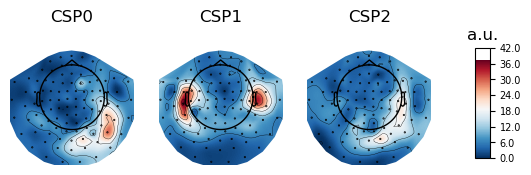

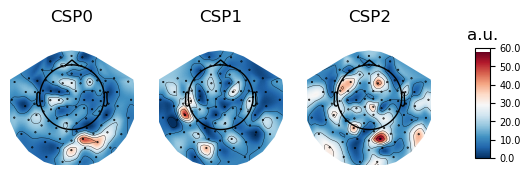

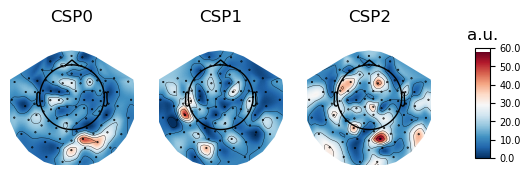

In [4]:
# Fit CSP on full data and plot
csp.fit(X, y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)